In [1]:
from PIL import Image
from torchvision import transforms 
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
import torch

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import h5py
import numpy as np
import torch
import torch.nn as nn
from math import sqrt
import matplotlib.pyplot as plt

#from dataset import CustomDataset

In [2]:
#dic with energies in eV of elements
dic={ 'Ca':3692,'Mn':5900,'Fe':6405,'Cu':8046,'Au':9713,'Hg':9989,'Pb':10551,'Sr':14165}
num_elements=len(dic)
#load h5 cubes panagia, jesus and hand
f = h5py.File('panagia1_mm.h5', 'r')
dset=f['dataset']
dEset=f['energies']
spectra_p=np.array(dset)
energies=np.array(dEset)
f.close()

f = h5py.File('christ.h5', 'r')
dset=f['dataset']
spectra_c=np.array(dset)
f.close()

f = h5py.File('hand.h5', 'r')
dset=f['dataset']
spectra_h=np.array(dset)
f.close()

In [3]:
#set the number of channels to cut
channels=100
#dimensions of images
rows_p=41
cols_p=65
rows_c=31
cols_c=46
rows_h=41
cols_h=21

#cut first #channels
spectra_p = spectra_p.astype(np.float32)
spectra_c = spectra_c.astype(np.float32)
spectra_h = spectra_h.astype(np.float32)
spectra_p=np.delete(spectra_p,np.s_[:channels],1)
spectra_c=np.delete(spectra_c,np.s_[:channels],1)
spectra_h=np.delete(spectra_h,np.s_[:channels],1)

energies=np.delete(energies,np.s_[:channels])

In [4]:
#Full width at half maximum     
def fwhm(ev):
    return sqrt(2.47*ev+4400)


In [5]:
X_p=torch.tensor(spectra_p)
X_c=torch.tensor(spectra_c)
X_h=torch.tensor(spectra_h)

In [6]:
#Calculate min and max channel of each elements in order to determine the range of interest
key_list=list(dic.keys())
min_ch=[]
max_ch=[]
min_roi_all=[]
max_roi_all=[]
for element in dic:
    min_roi=(dic[element]-fwhm(dic[element])/2)
    min_roi_all.append(min_roi)
    max_roi=(dic[element]+fwhm(dic[element])/2)
    max_roi_all.append(max_roi)
    min_ch.append(int((min_roi+960)/20)-channels)
    max_ch.append(int((max_roi+960)/20)-channels)

#Create target vectors according to ROI
y_p=np.zeros([len(spectra_p),num_elements])
for i in range(len(spectra_p)):
    for j in range(len(key_list)):
        y_p[i][j]=np.sum(np.sum(spectra_p[i,min_ch[j]:max_ch[j]]))
y_c=np.zeros([len(spectra_c),num_elements])
for i in range(len(spectra_c)):
    for j in range(len(key_list)):
        y_c[i][j]=np.sum(np.sum(spectra_c[i,min_ch[j]:max_ch[j]]))
y_h=np.zeros([len(spectra_h),num_elements])
for i in range(len(spectra_h)):
    for j in range(len(key_list)):
        y_h[i][j]=np.sum(np.sum(spectra_h[i,min_ch[j]:max_ch[j]]))
#convert target vectors to tensors
y_p, y_c, y_h = torch.tensor(y_p), torch.tensor(y_c), torch.tensor(y_h)

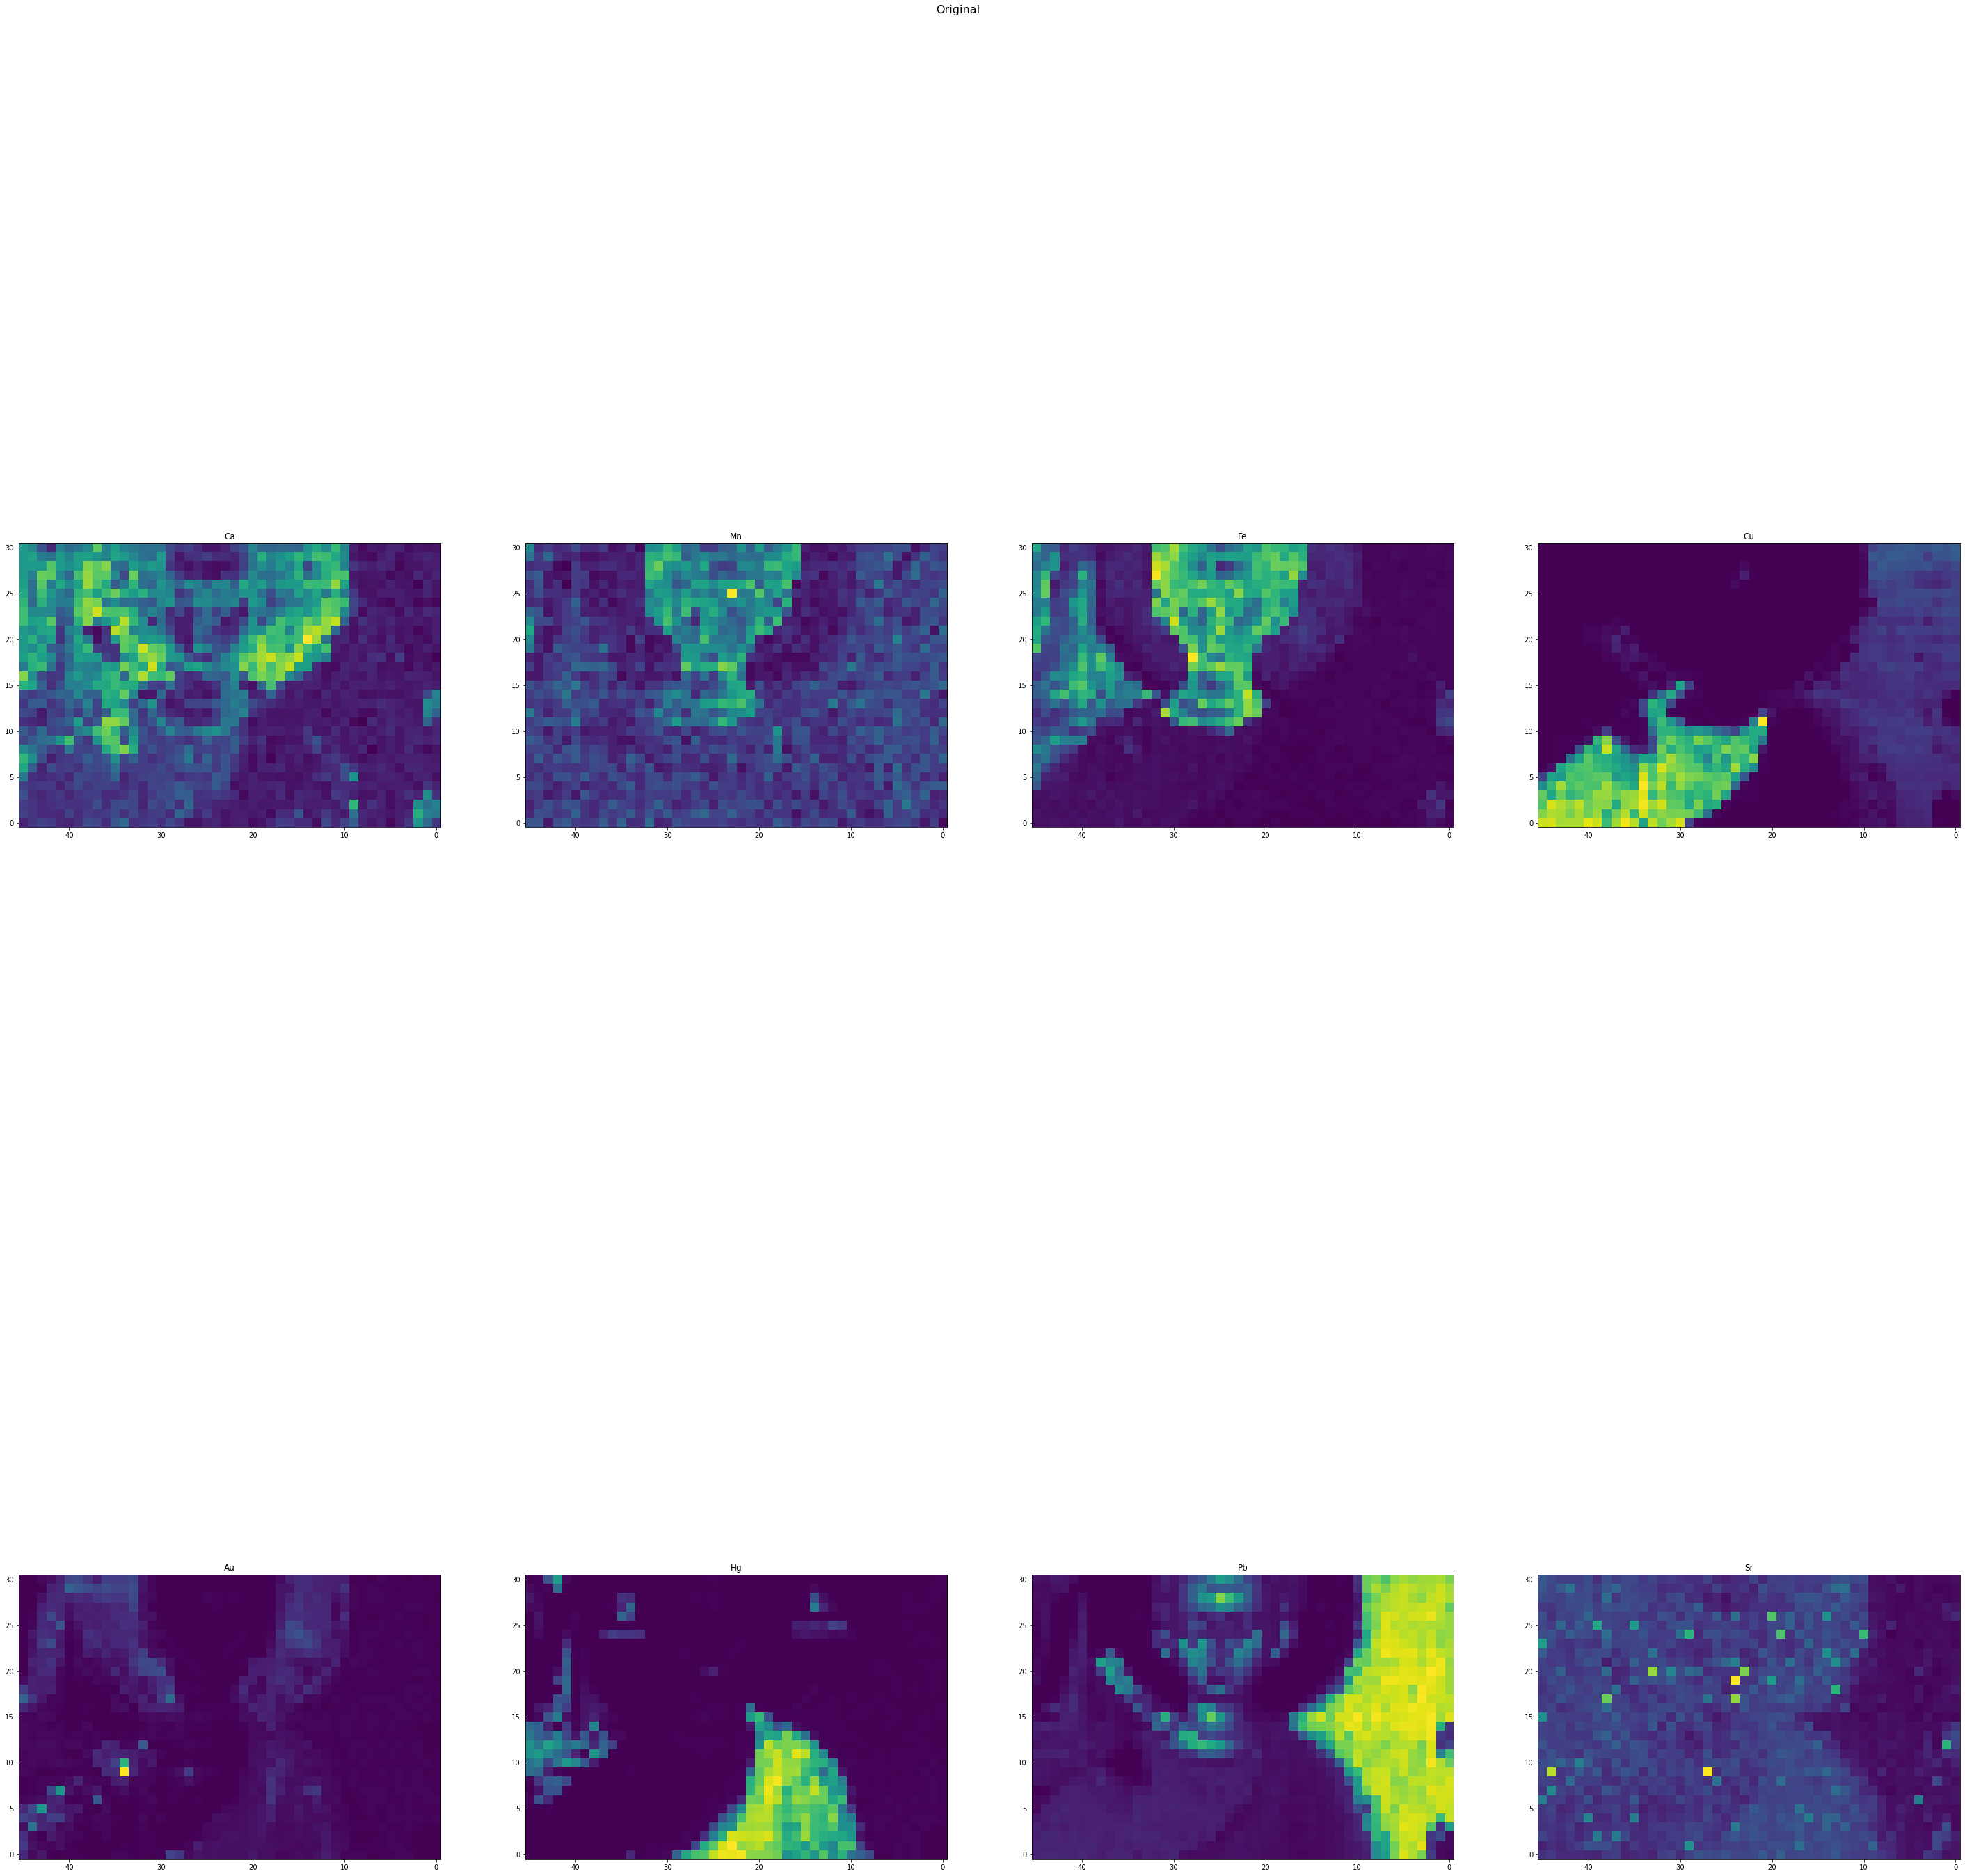

In [7]:
image=y_c.reshape(rows_c,cols_c,8)
fig, ax = plt.subplots(nrows=2,ncols=4)
fig.set_figheight(50)
fig.set_figwidth(50)
fig.suptitle('Original', fontsize=16)
k=0
for i in range(2):
    for j in range(4):
        ax[i][j].imshow(image[:,:,k])
        ax[i][j].invert_yaxis()
        ax[i][j].invert_xaxis()
        ax[i][j].title.set_text(key_list[k])
        k+=1

In [8]:
imagesToTrain = [
    torch.cat((X_h, y_h), dim=1),
    torch.cat((X_p, y_p), dim=1),
]

imagesToTest = [
    torch.cat((X_c, y_c), dim=1),
]

In [9]:
# Hyper-parameters 
input_size = len(spectra_p[0])
hidden_size = 100
output_size = len(key_list)
num_epochs = 500
batch_size = 32
learning_rate = 0.0002

In [10]:
class CustomDataset(Dataset):
    
    def __init__(self, listOfFlattenedImages, numChannels=1948, numElements=8):
        self.numChannels = numChannels
        self.numElements = numElements
        self.images = torch.cat(listOfFlattenedImages, dim=0)


    def __getitem__(self, index):
        return self.images[index, :self.numChannels].float(), self.images[index, self.numChannels:].float()
    
    
    def __len__(self):
        return self.images.shape[0]



In [11]:
trainSet = CustomDataset(imagesToTrain, numChannels=1948, numElements=8)

trainLoader = DataLoader(
    dataset=trainSet, 
    batch_size=batch_size, 
    shuffle=True
)

testSet = CustomDataset(imagesToTest, numChannels=1948, numElements=8)

testLoader = DataLoader(
    dataset=testSet, 
    batch_size=batch_size, 
    shuffle=False
)

In [12]:
class ConvModel(nn.Module):
    def __init__(self, num_features, in_channels, num_targets, poolSize=5, kernel_size=5, stide=1, padding=1):

        super(ConvModel, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=1, 
                kernel_size=kernel_size, stride=stide, padding=padding),
            nn.ReLU(),
            nn.MaxPool1d(poolSize)
        )

        self.l1 = nn.Sequential(
            nn.Linear(num_features // poolSize, 100),
            nn.ReLU()
        )

        self.lOut = nn.Sequential(
            nn.Linear(100, num_targets),
            nn.ReLU()
        )

    def forward(self, x_in):
        x1 = self.conv1(x_in)
        x2 = self.l1(x1)
        xOut = self.lOut(x2)
        return xOut

In [13]:
model = ConvModel(num_features=1948, in_channels=1, num_targets=8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [37]:
epoch_losses=[]
test_losses=[]
for epoch in range(num_epochs):

    ### TRAINING ### 
    epoch_loss = 0

    for x_in, y_in in trainLoader:
        optimizer.zero_grad()

        x_in = torch.reshape(x_in, (x_in.shape[0], 1, x_in.shape[1]))    
        y_in = torch.reshape(y_in, (y_in.shape[0], 1, y_in.shape[1]))    

        y_out = model(x_in)

        loss = criterion(y_in, y_out)

        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    ### TESTING ### 
    test_loss = 0
    for x_in, y_in in testLoader:
        
        x_in = torch.reshape(x_in, (x_in.shape[0], 1, x_in.shape[1]))    
        y_in = torch.reshape(y_in, (y_in.shape[0], 1, y_in.shape[1]))    

        with torch.no_grad():
            y_out = model(x_in)
            loss = criterion(y_in, y_out)
            test_loss += loss.item() 
     
    print(epoch, epoch_loss, test_loss)
    epoch_losses.append(epoch_loss)
    test_losses.append(test_loss)

0 1057.575786113739 22122.746215820312
1 1040.607970237732 19082.386753082275
2 1075.374406337738 19366.87586593628
3 1055.708815574646 18728.403759002686
4 1055.110441684723 23672.109691619873
5 1064.2321634292603 23411.621299743652
6 1061.2623205184937 19749.500904083252
7 1046.1137943267822 22193.533531188965
8 1077.0609259605408 21088.816707611084
9 1070.5303692817688 22654.987762451172
10 1066.6534008979797 24765.133979797363
11 1044.6639757156372 17328.099151611328
12 1063.8925652503967 21063.803638458252
13 1053.7688508033752 16370.457710266113
14 1063.7718148231506 17892.685386657715
15 1043.2569208145142 18812.975971221924
16 1024.2486844062805 16007.228572845459
17 1049.177342414856 22872.53450012207
18 1049.7423191070557 26345.165634155273
19 1052.4096794128418 21521.49602508545
20 1065.4120783805847 18681.811862945557
21 1050.5238952636719 22299.63237762451
22 1068.6181826591492 20888.760078430176
23 1066.607361793518 22079.007167816162
24 1058.7652201652527 18386.250034332

203 973.6126885414124 16370.535991668701
204 961.4114243984222 16333.134155273438
205 978.1650404930115 16195.015480041504
206 967.6164932250977 17013.289993286133
207 968.9552483558655 16519.722103118896
208 964.3878874778748 17729.186992645264
209 991.5377378463745 18897.42067718506
210 991.4996829032898 16268.331558227539
211 973.7808690071106 15271.514011383057
212 979.2221994400024 15679.965156555176
213 957.3345274925232 17266.707927703857
214 960.2922167778015 17670.943279266357
215 954.1896080970764 17267.026641845703
216 952.6686396598816 16901.357791900635
217 966.0852308273315 19785.956230163574
218 949.6204633712769 17905.228019714355
219 980.0056166648865 17787.348194122314
220 972.3456425666809 15471.007110595703
221 983.9112944602966 16136.727207183838
222 958.986444234848 18631.677574157715
223 977.6923582553864 16266.51160812378
224 957.130793094635 18241.502307891846
225 990.9265561103821 17217.82862472534
226 949.1772146224976 15742.83808517456
227 956.3443636894226 

406 931.5251297950745 15606.043849945068
407 921.5459055900574 18579.126125335693
408 916.1154565811157 22090.40906906128
409 916.9358115196228 20120.592575073242
410 931.1922817230225 20486.42124557495
411 930.8763780593872 19245.668815612793
412 918.2943234443665 16829.154388427734
413 919.2198753356934 18182.458419799805
414 927.9309496879578 21438.950664520264
415 942.6016454696655 19148.91128540039
416 954.8533425331116 18959.51295852661
417 924.1443529129028 18624.18744277954
418 921.5110607147217 18110.63047027588
419 914.9579849243164 20039.057914733887
420 911.6442346572876 19158.64672088623
421 931.2073483467102 19527.99045562744
422 919.3541612625122 21954.14649963379
423 932.1405463218689 17873.82217025757
424 925.0621190071106 19784.041931152344
425 903.7914352416992 17816.06081008911
426 919.0980949401855 21209.206325531006
427 922.4670758247375 21539.061012268066
428 926.5703959465027 19108.590183258057
429 929.2617726325989 21218.806518554688
430 921.704231262207 22130.

In [38]:
%matplotlib qt 
plt.plot(epoch_losses)
plt.plot(test_losses)
plt.title("CNN-learning rate:"+str(learning_rate))

Text(0.5, 1.0, 'CNN-learning rate:0.0002')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\eventloops.py:106: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  app.exec_()


In [39]:
y_out=model(X_c.reshape(X_c.shape[0],1,X_c.shape[1]))
a=y_out.detach().numpy()
a=a.reshape(rows_c*cols_c,8)
y_out = a.reshape(rows_c,cols_c,8)

In [40]:
fig, ax = plt.subplots(nrows=2,ncols=4)
fig.set_figheight(50)
fig.set_figwidth(50)
fig.suptitle('Prediction CNN', fontsize=16)
k=0
for i in range(2):
    for j in range(4):
        ax[i][j].imshow(y_out[:,:,k])
        ax[i][j].invert_yaxis()
        ax[i][j].invert_xaxis()
        ax[i][j].title.set_text(key_list[k])
        k+=1

In [41]:
y_detached=y_c.detach().numpy()
fig, ax = plt.subplots(nrows=2,ncols=4)
fig.suptitle('CNN', fontsize=16)
r=0
c=0
for el in range(len(key_list)):
    min_el=np.min(y_detached[:,el])
    max_el=np.max(y_detached[:,el])
    #print(key_list[el],min_el,max_el)
    step=(max_el-min_el)/40
    limits=[x for x in np.arange(min_el,max_el,step)]
    x_ax=[]
    for x in range(len(limits)-1):
        x_ax.append((limits[x]+limits[x+1])/2.)
    counts=np.zeros(len(limits)-1)
    counts_pr=np.zeros(len(limits)-1)
    for i in range(len(y_detached)):
        for k in range(len(counts)):
            if y_detached[i,el]>=limits[k] and y_detached[i,el]<=limits[k+1] :
                counts[k]+=1
            if a[i,el]>=limits[k] and a[i,el]<=limits[k+1] :
                counts_pr[k]+=1
    ax[r][c].set_yscale('log')
    ax[r][c].plot(x_ax,counts)
    ax[r][c].plot(x_ax,counts_pr)
    ax[r][c].title.set_text(key_list[el])
    c+=1
    if c==4:
        c=0
        r+=1
fig.legend(['real','prediction'])

In [23]:
y_detached.shape

(1426, 1, 8)